In [74]:
from __future__ import division
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy as np
import seaborn as sns
%matplotlib inline

In [75]:
#The below contains all of the necessary splicing and renaming, etc., done during my exploratory analysis.

df = pd.read_csv("../my_hw_repo/Fangraphs_2012.csv")
df2 = pd.read_csv("../my_hw_repo/Fangraphs_2013.csv")
df3 = pd.read_csv("../my_hw_repo/Fangraphs_2014.csv")
df4 = pd.read_csv("../my_hw_repo/Fangraphs_2015.csv")
df5 = pd.read_csv("../my_hw_repo/Fangraphs_2016.csv")

batters = df.append(df2).append(df3).append(df4).append(df5)
#Combined 2012-2016 data into one dataframe called "batters"

batters = batters[["Age", "PA", "SB", "BABIP", "GB%", "LD%", "HR/FB"]]
#Kept the features I think may be relevant

batters['GB%'] = batters['GB%'].apply(lambda x: x[0:3]).astype(float)/100
batters['LD%'] = batters['LD%'].apply(lambda x: x[0:3]).astype(float)/100
batters['HR/FB'] = batters['HR/FB'].apply(lambda x: x[0:3]).astype(float)/100
#Converted the strings to floats, confirmed below by showing data types

batters = batters[batters['PA'] > 200]

batters['SB'] = batters['SB']/batters['PA'] #Change from raw SB totals to SB/PA - a proxy for speed
batters = batters[["Age", "SB", "BABIP", "GB%", "LD%", "HR/FB"]] #Deleted PA variable, not relevant anymore
batters.rename(columns = {'SB':'SBperPA', 'GB%':'GB', 'LD%':'LD', 'HR/FB':'HRperFB'}, inplace = True)
#Renamed columns for various reasons - mostly so they can be used later without % or / characters in them

batters.describe().round(3)

,Age,SBperPA,BABIP,GB,LD,HRperFB
count,1753.000,1753.000,1753.000,1753.000,1753.000,1753.000
mean,28.547,0.015,0.301,0.439,0.205,0.108
std,3.984,0.019,0.037,0.068,0.031,0.058
min,19.000,0.000,0.185,0.190,0.120,0.000
25%,26.000,0.003,0.275,0.390,0.190,0.066
50%,28.000,0.009,0.301,0.430,0.210,0.100
75%,31.000,0.021,0.324,0.480,0.220,0.140
max,42.000,0.142,0.411,0.670,0.310,0.400


In [88]:
from sklearn.cross_validation import train_test_split

X, y = batters.loc[:, ['Age', 'SBperPA', 'GB', 'LD', 'HRperFB']].values, batters.loc[:, 'BABIP'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [89]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [106]:
y = y_train
X = sm.add_constant(X_train_std)
model1 = sm.OLS(endog=y, exog=X)
result = model1.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     163.3
Date:                Tue, 28 Mar 2017   Prob (F-statistic):          7.60e-137
Time:                        14:04:37   Log-Likelihood:                 2947.8
No. Observations:                1402   AIC:                            -5884.
Df Residuals:                    1396   BIC:                            -5852.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3012      0.001    380.805      0.000         0.300     0.303
x1            -0.0049      0.001     -6.142      0.000        -0.007    -0.003
x2             0.0064      0.001      7.549      0.000         0.005     0.008
x3             0.0103      0.001     11.863      0.000         0.009     0.012
x4             0.0196      0.001     23.889      0.000         0.018     0.021
x5             0.0093      0.001     11.029      0.000         0.008     0.011
==============================================================================
Omnibus:                        7.104   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.954
Skew:                           0.102   Prob(JB):                       0.0187
Kurtosis:                       3.308   Cond. No.                         1.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
np.mean((model1.predict(X_test_std)-y_test)**2)

#I can't figure out whY I'm getting this error. I need an MSE here to compare to MSEs from RandomForest.

ValueError: shapes (1402,6) and (351,5) not aligned: 6 (dim 1) != 351 (dim 0)

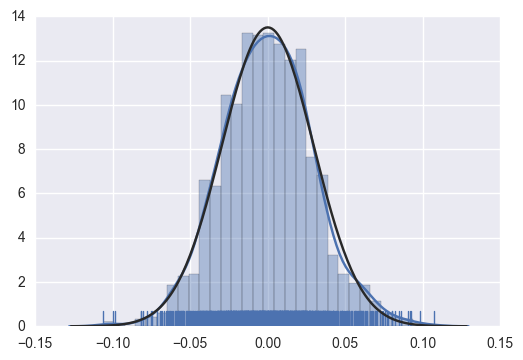

In [108]:
from scipy.stats import norm, normaltest, describe
sns.distplot(result.resid, fit=norm, rug=True);

In [109]:
stat, p = normaltest(result.resid)
p

0.02866802750245161

Note: There DOES appear to be significance to all of the correlations, based on 95% confidence intervals - negative for Age (x1), positive for each other variable, with LD% (x4) being the most important. HOWEVER - the residuals of even the scaled data are not normally distributed enough to use this model (close, but I want p > 5%. Due to the non-normality of the model, I'm going to move on to a different method.

In [120]:
from sklearn.ensemble import RandomForestRegressor

X, y = batters.loc[:, ['Age', 'SBperPA', 'GB', 'LD', 'HRperFB']], batters.loc[:, 'BABIP']

model2 = RandomForestRegressor(n_estimators = 10)
model2.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [121]:
features = X.columns
feature_importances = model2.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
3,LD,0.273168
1,SBperPA,0.206251
4,HRperFB,0.202297
2,GB,0.169455
0,Age,0.148829


CV MSE [-0.0011398  -0.00104061 -0.00101302], Average MSE -0.00106447629179
n trees: 1, CV MSE [-0.00186408 -0.00185516 -0.0019818 ], Average MSE -0.00190034413515
n trees: 6, CV MSE [-0.00106563 -0.00112354 -0.00114139], Average MSE -0.00111018537983
n trees: 11, CV MSE [-0.00102893 -0.0010397  -0.0010109 ], Average MSE -0.00102651222656
n trees: 16, CV MSE [-0.0010386  -0.00104433 -0.00098883], Average MSE -0.00102391921379
n trees: 21, CV MSE [-0.00103899 -0.00099085 -0.0009346 ], Average MSE -0.00098815017696
n trees: 26, CV MSE [-0.00104226 -0.0009908  -0.00095177], Average MSE -0.000994940596459
n trees: 31, CV MSE [-0.00100957 -0.00099298 -0.0009073 ], Average MSE -0.00096994862756
n trees: 36, CV MSE [-0.00101191 -0.00100058 -0.00093565], Average MSE -0.000982714633994
n trees: 41, CV MSE [-0.00101    -0.00097496 -0.00094202], Average MSE -0.000975661472951
n trees: 46, CV MSE [-0.0010008  -0.00098111 -0.00093695], Average MSE -0.000972952763647
n trees: 51, CV MSE [-0.0009966 

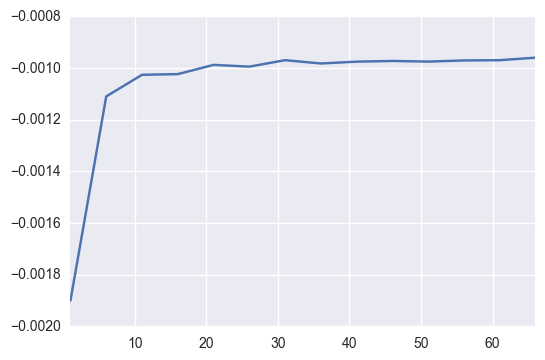

In [122]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model2, X, y, scoring='neg_mean_squared_error')
print('CV MSE {}, Average MSE {}'.format(scores, scores.mean()))

mse_scores = {}
for n_trees in range(1, 70, 5):
    model = RandomForestRegressor(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error')
    print('n trees: {}, CV MSE {}, Average MSE {}'.format(n_trees, scores, scores.mean()))
    mse_scores[n_trees] = scores.mean()
pd.Series(mse_scores, name='MSE Scores').plot();

Note: The MSE decreases slow down between and 10 and 20. I will use 20 going forward.

In [123]:
model2 = RandomForestRegressor(n_estimators = 20)
model2.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [124]:
features = X.columns
feature_importances = model2.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
3,LD,0.274665
4,HRperFB,0.200924
1,SBperPA,0.200270
2,GB,0.178018
0,Age,0.146124


As expected, Line Drive % is the most important predictor. The others are less so - the least important is age, which as we know from earlier, is negatively correlated with BABIP.

In [125]:
#Just to see how the model works, I'll predict the 2016 BABIP of a few notable players.

BryceHarper_2016 = {'Age': 23, 'SBperPA': 0.033, 'GB': 0.404, 'LD': 0.172, 'HRperFB': 0.143}
df = pd.Series(data=BryceHarper_2016, index = BryceHarper_2016.keys())
model2.predict(df)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.2422])

In [126]:
AlbertPujols_2016 = {'Age': 36, 'SBperPA': 0.006, 'GB': 0.439, 'LD': 0.166, 'HRperFB': 0.150}
df = pd.Series(data=AlbertPujols_2016, index = AlbertPujols_2016.keys())
model2.predict(df)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.2348])

In [127]:
JoseAltuve_2016 = {'Age': 26, 'SBperPA': 0.042, 'GB': 0.416, 'LD': 0.262, 'HRperFB': 0.130}
df = pd.Series(data=JoseAltuve_2016, index = JoseAltuve_2016.keys())
model2.predict(df)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.2475])

NOTE: Jose Altuve had one of the highest line-drive percentages in the league (26.2%) while also being relatively young (26), yet this is predicting a well below average BABIP (league average = .301). Is this because of the standardization that was done? It looks like every value is way too low. How do I deal with this if I want to use the model to make real predictions going forward?